Import and config section

In [1]:
import tensorflow as tf
from tensorflow.python.platform import gfile
from tensorflow.python.util import compat
from tensorflow.core.protobuf import saved_model_pb2
import os
import cv2
import numpy as np
from matplotlib import pyplot as plt
import time

# This is needed to display the images.
%matplotlib inline

# Types of traffic lights
image_types = ["Red", "Green", "Yellow"]

# Path to our trained model
model_path = "./model/model_combined.pb"

# Activate optimizations for TF
config = tf.ConfigProto()
jit_level = tf.OptimizerOptions.ON_1
config.graph_options.optimizer_options.global_jit_level = jit_level
print("using tensorflow version", tf.__version__)

('using tensorflow version', '1.3.0')


Load the trained models into TensorFlow

In [2]:
# Function to load a graph from a protobuf file
def _load_graph(graph_file, config, verbose = False):
    with tf.Session(graph=tf.Graph(), config=config) as sess:
        assert tf.get_default_session() is sess
        gd = tf.GraphDef()
        with tf.gfile.Open(graph_file, 'rb') as f:
            data = f.read()
            gd.ParseFromString(data)
        tf.import_graph_def(gd, name='')
        graph = tf.get_default_graph()
        if verbose:
            print ('Graph v' + str(graph.version) + ', nodes: '+ ', '.join([n.name for n in graph.as_graph_def().node]))
        return graph
    
# Function to load the SqueezeNet Classification module
def load_graph_classification():
    model_path = os.path.join('model', 'model_classification.pb')
    with tf.Session(graph=tf.Graph(), config=config) as sess:
        gd = tf.GraphDef()
        with tf.gfile.Open(model_path, 'rb') as f:
            data = f.read()
            gd.ParseFromString(data)
        tf.import_graph_def(gd, name='')
        return sess.graph
    
# Function to load the RFCN-Resnet101 detection module
def load_graph_detection():
    model_path = os.path.join('model', 'model_detection.pb')
    with tf.Session(graph=tf.Graph(), config=config) as sess:
        with gfile.FastGFile(model_path, 'rb') as f:
            data = compat.as_bytes(f.read())
            sm = saved_model_pb2.SavedModel()
            sm.ParseFromString(data)
            tf.import_graph_def(sm.meta_graphs[0].graph_def, name='')
        return sess.graph

config = tf.ConfigProto()
jit_level = tf.OptimizerOptions.ON_1
config.graph_options.optimizer_options.global_jit_level = jit_level
# Load graphs
#detection_path = os.path.join('model', 'model_detection_small.pb')
#classification_path = os.path.join('model', 'model_classification.pb')

graph_detection = _load_graph(os.path.join('model', 'ssd_mobilenet_v1_coco_2017_11_17.pb'), config)
#graph_detection = load_graph_detection()
graph_classification = load_graph_classification()
print("Models loaded!", len(graph_detection.as_graph_def().node), "nodes")

#print([node.name for node in graph_detection.as_graph_def().node])

('Models loaded!', 5990, 'nodes')


Load the images from the test_images folder

In [3]:
# Those are the paths for our test images
image_paths = [ os.path.join('test_images', 'image{}.jpg'.format(i)) for i in range(0, 15) ]

# Load the images and store them into a list
images = []
for image_path in image_paths:
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) 
    images.append(image)
    
print(len(images), "Test images loaded!")

(15, 'Test images loaded!')


Get the tensors from graph we need for detection

In [4]:
# Definite input and output Tensors for detection_graph
image_tensor = graph_detection.get_tensor_by_name('image_tensor:0')

# Each box represents a part of the image where a particular object was detected
detection_boxes = graph_detection.get_tensor_by_name('detection_boxes:0')

# Each score represent how level of confidence for each of the objects
detection_scores = graph_detection.get_tensor_by_name('detection_scores:0')

# Get input and output tensors for the classification
in_graph = graph_classification.get_tensor_by_name('input_1_1:0')
out_graph = graph_classification.get_tensor_by_name('output_0:0')

This method extracts the traffic light bounding boxes with specified confidence level

In [5]:
def extractBox(boxes, scores, confidence):
    # Prepare stuff
    boxes = np.squeeze(boxes)
    scores = np.squeeze(scores)
        
    # Get bounding box with highest confidence
    maxConf = 0
    number = -1
    for i in range(boxes.shape[0]):
        if scores[i] > confidence:
            if scores[i] > maxConf:
                maxConf = scores[i]
                number = i
                
    if number != -1:
        # Create a tuple for earch box
        box = tuple(boxes[number].tolist())
              
        # Extract box corners
        ymin, xmin, ymax, xmax = box
        (left, right, top, bottom) = (xmin * im_width, xmax * im_width, 
                            ymin * im_height, ymax * im_height)
                
        # Expand them a little bit
        left = left - 5
        if left < 0:
            left = 0
        top = top - 10
        if top < 0:
            top = 0
        bottom = bottom + 10
        if bottom > im_height:
            bottom = im_height
        right = right + 5
        if right > im_width:
            right = im_width
        box = int(left), int(right), int(top), int(bottom)
        return box
    
    else:
        return None

With this method we can draw the bounding boxes and write labels for visualisation

In [6]:
def drawResult(box, label, image):
    font = cv2.FONT_HERSHEY_DUPLEX
    left, right, top, bottom = box
    cv2.rectangle(image, (left, top), (right, bottom), (255, 0, 0), 2)    
    cv2.putText(image, label, (left, bottom + 40), font, 1, (255, 0, 0), 1, cv2.LINE_AA)
    return image

Do the inference here and show results

('Detecttion in ms', 2620.5661296844482)
('Detecttion in ms', 235.94903945922852)
('Detecttion in ms', 575.3309726715088)
('Detecttion in ms', 502.53796577453613)
('Detecttion in ms', 237.49303817749023)
('Detecttion in ms', 511.8119716644287)
('Detecttion in ms', 492.66695976257324)
('Detecttion in ms', 398.0088233947754)
('Detecttion in ms', 425.4150390625)
('Detecttion in ms', 208.1739902496338)
('Detecttion in ms', 245.03803253173828)
('Detecttion in ms', 235.34107208251953)
('Detecttion in ms', 209.88798141479492)
('Detecttion in ms', 228.75499725341797)
('Detecttion in ms', 244.78483200073242)
('Classifiaction in ms', 158.16998481750488)
('Classifiaction in ms', 66.52593612670898)
('Classifiaction in ms', 36.96393966674805)
('Classifiaction in ms', 0.3330707550048828)
('Classifiaction in ms', 36.23795509338379)
('Classifiaction in ms', 47.90997505187988)
('Classifiaction in ms', 0.21004676818847656)
('Classifiaction in ms', 69.68283653259277)
('Classifiaction in ms', 0.6089210510

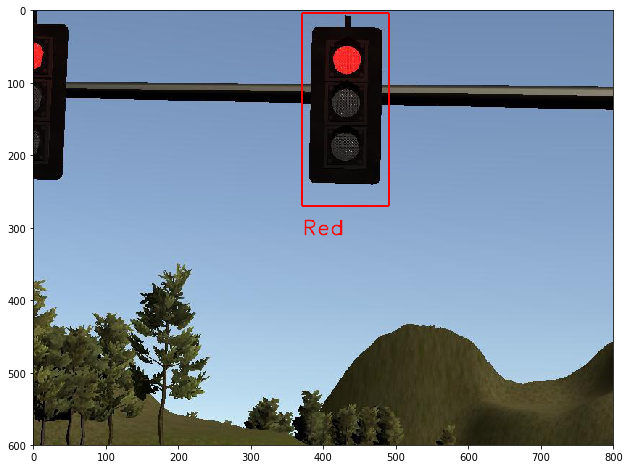

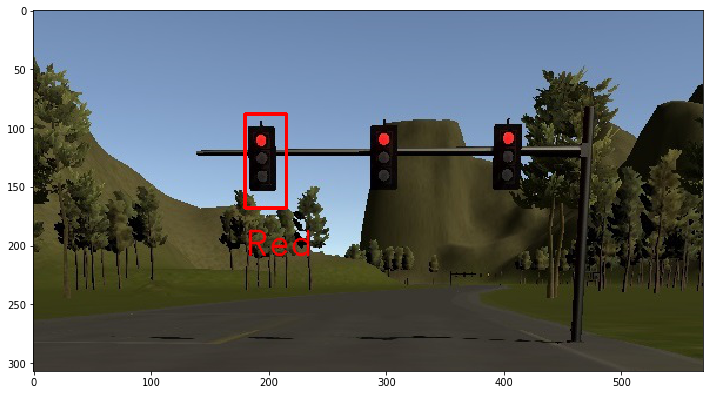

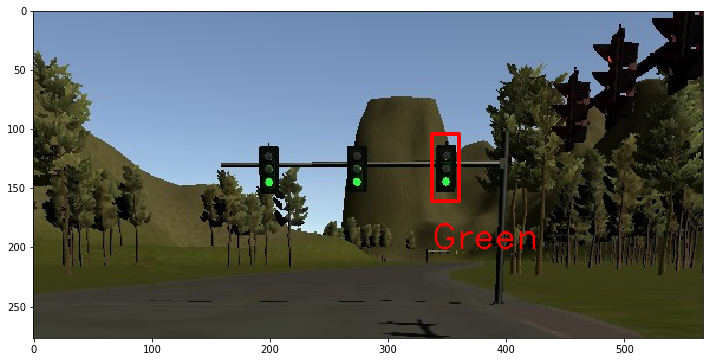

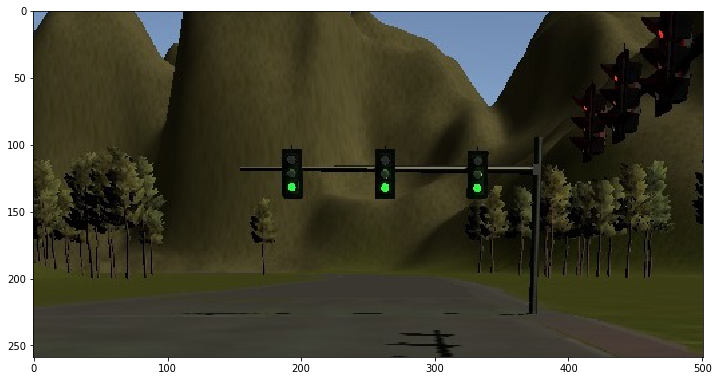

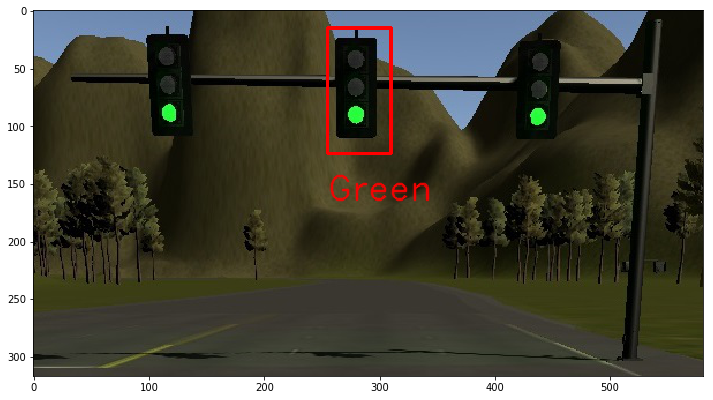

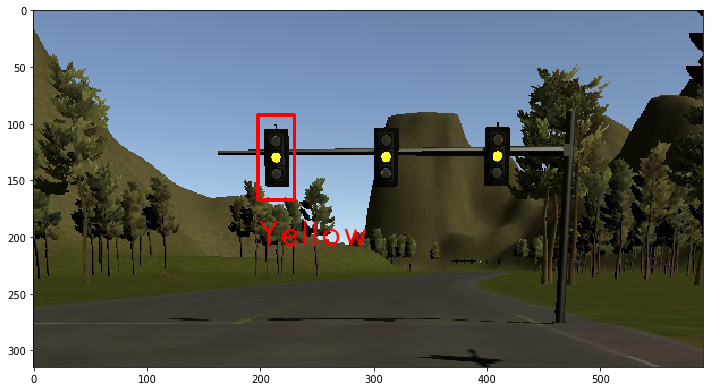

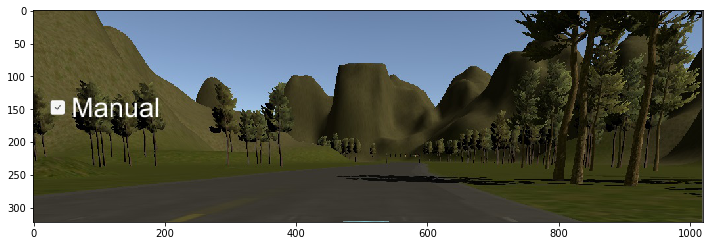

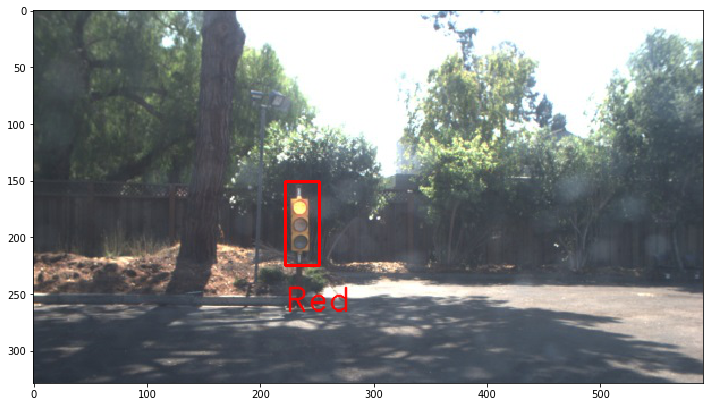

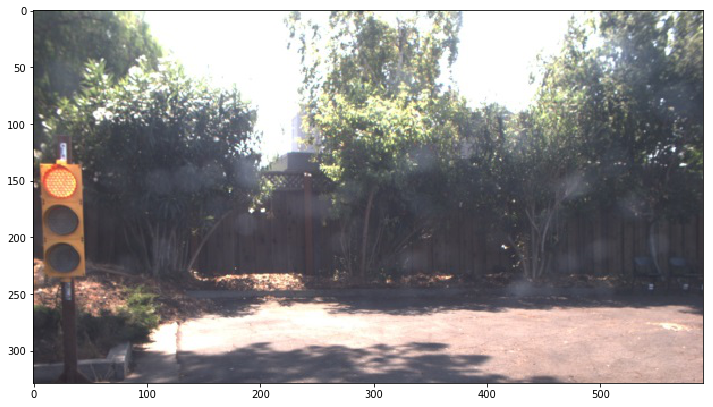

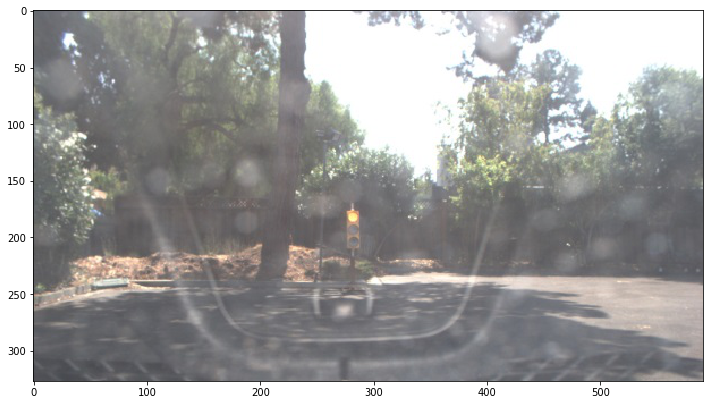

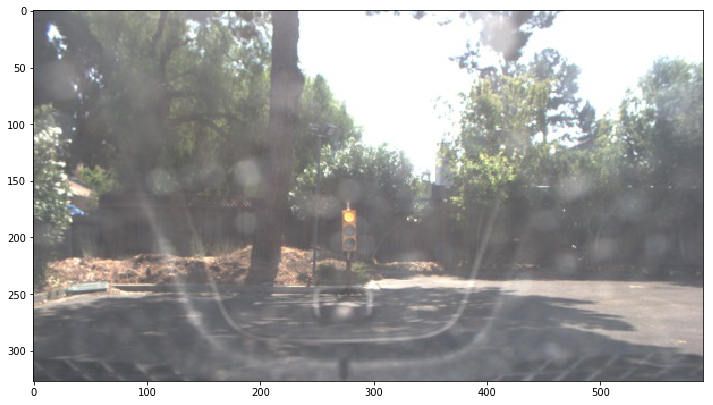

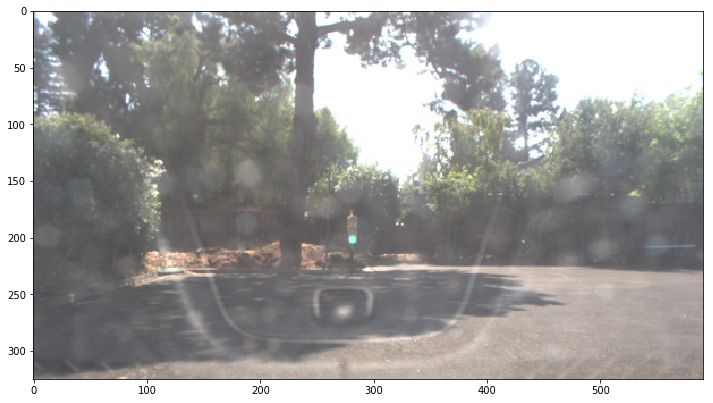

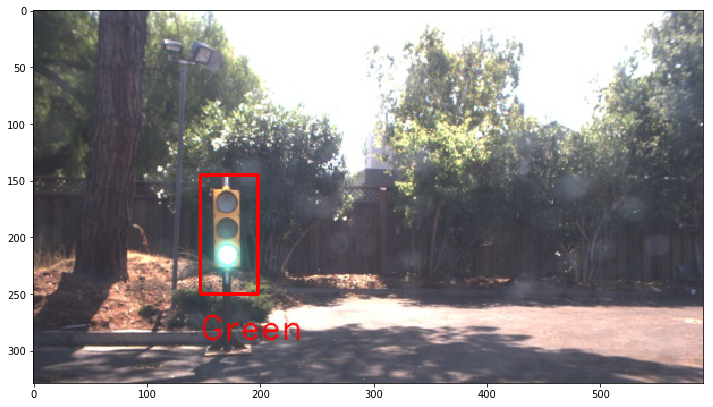

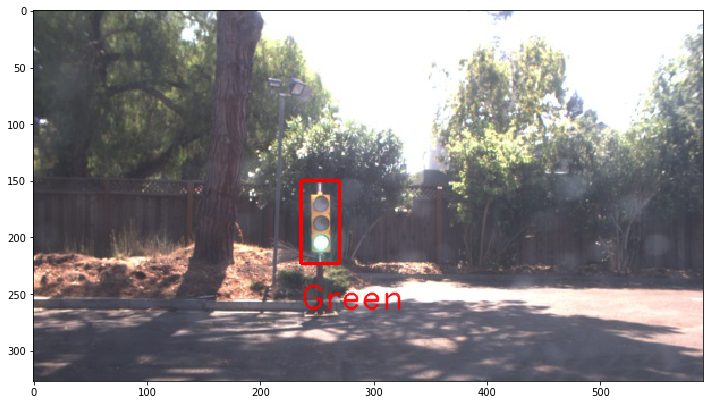

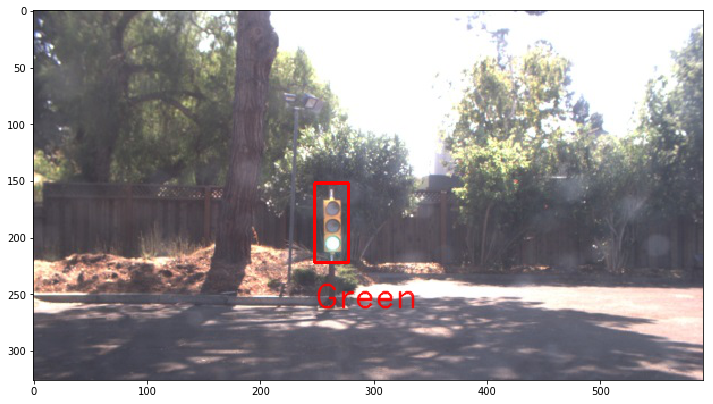

In [7]:
# Detection
boxList = []
with tf.Session(graph=graph_detection, config=config) as sess:    
    # Go through all images
    for i in range(0, len(images)):
        time0 = time.time()
        # Load image and convert
        image = np.copy(images[i])
        im_height, im_width, _ = image.shape
        image_expanded = np.expand_dims(image, axis=0)
        
        # Do the inference
        boxes, scores = sess.run([detection_boxes, detection_scores],
          feed_dict={image_tensor: image_expanded})
        
        # Extract box and append to list
        box = extractBox(boxes, scores, 0.5)
        boxList.append(box)
        time1 = time.time()
        print("Detecttion in ms", (time1 - time0) * 1000) 

# Classification
trafficLights = []
with tf.Session(graph=graph_classification, config=config) as sess:   
    # Go through all images
    for i in range(0, len(images)): 
        time0 = time.time()
        box = boxList[i]
        image = np.copy(images[i])
        if box != None:
            left, right, top, bottom = box
            img_crop = image[top:bottom, left:right]
            traffic_light = cv2.resize(img_crop, (32, 32))
            sfmax = list(sess.run(tf.nn.softmax(out_graph.eval(feed_dict={in_graph: [traffic_light]}))))
            sf_ind = sfmax.index(max(sfmax))
            predicted_label = image_types[sf_ind]
            trafficLights.append(str(predicted_label))
        else:
            trafficLights.append('Unknown')
        time1 = time.time()
        print("Classifiaction in ms", (time1 - time0) * 1000)
            
# Show results
for i in range(0, len(images)): 
    image = np.copy(images[i])
    box = boxList[i]
    trafficLight = trafficLights[i]
    # Draw the box if found
    if box != None:
        image = drawResult(box, trafficLight, image)
    # Draw image
    plt.figure(figsize=(12, 8))
    plt.imshow(image)